In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

import openseespy.opensees as ops
import opsvis as opsv

from standes.analysis.pushover import cyclic_ramp, multi_cycle_ramp
from standes.opsmodels.fibresections import fibre_CircularHollowSection_basic
from standes.opsmodels.materials import chs_epsilon_0
from standes.opsmodels.buckling import basic_buckling_element
from standes.opsmodels.gussets import gusset_hinge
from standes.opsmodels.braces import karamanci_brace

# Verifying the Modelling Procedure for Buckling Braces according to Karamanci and Lignos 2014

## Basic input parameters

In [4]:
# Brace geometric information --> section Pipe 5 (Pipe 127) from AISC 16
diameter = 141.3                  # mm --> from Dlubal data
wall_thickness = 6.6            # mm --> from Dlubal data
Area = 2587                     # mm² --> area from RESSLab data
I_y = 5950000                   # mm --> second moment of area from RESSLab data
W_ely = 89230                   # mm3 --> elastic section modulus from Dlubal pipe5
W_ply = 112000                  # mm3 --> plastic section modulus from RESSLab data
i_z = 47.8                      # mm --> radius of gyration
J = 12596500                    # mm4 --> Torsion constant -- Dlubal Pipe5

brace_length = 3010             # mm --> total length of brace element
k_restraint = 1.0               # mm --> assumed k value for Euler buckling (RESSLab)
alpha = 0.                      # ° --> angle of brace

# Brace material properties
E_steel = 200e3                 # MPa
G_steel = 79e3                  # assumed. Value not specified in Fell et al. 2009
f_ym = 326                      # MPa --> measured yield strength prior to testing
f_y_gp = 345                    # MPa --> nominal yield strenght of the gusset plates

# Gusset plate geometry
whitmore_width = 457            # mm --> 508 - 2 * 25.4
effective_length = 38           # mm --> due to test geometry there is not buckling and limited elastic flexibility in gusset plate
gusset_thickness = 12.7         # mm

# brace model parameters
n_segments = 8
n_int_points = 5
n_fibres_circumference = 12
n_fibres_thickness = 4
oos = 0.001                     # 0.1% out of straightness to initialise buckling

# material parameters
b = 0.005
R_0 = 24.0
cR_1 = 0.925
cR_2 = 0.250
a_1 = 0.02
a_2 = 1.0
a_3 = 0.02
a_4 = 1.0
m = -0.3


In [5]:
# calculated properties
slenderness = k_restraint * brace_length / i_z
epsilon_0 = 0.748 * slenderness ** (-0.399) * (diameter / wall_thickness) ** (-0.628) * (E_steel / f_ym) ** 0.201

print(f"slenderness (kL/r) = {slenderness:.2f}")
print(f"epsilon_0 = {epsilon_0:.5f}")

slenderness (kL/r) = 62.97
epsilon_0 = 0.07599


## Testing the fibre section

### Analysis with basic steel materials

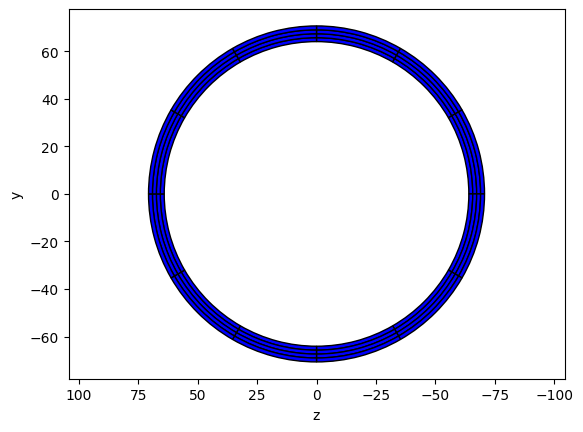

In [6]:
# create basic model of the fibre section
ops.wipe()
ops.model("basic", "-ndm", 3)

ops.node(1, 0, 0, 0, 0, 0, 0)
ops.node(2, 0, 0, 0, 0, 0, 0)

ops.fix(1, 1, 1, 1, 1, 1, 1)
ops.fix(2, 1, 1, 1, 1, 0, 1)

# material
mat_tag = 1
# ops.uniaxialMaterial("Elastic", mat_tag, E_steel)              # simple material for testing
# ops.uniaxialMaterial("Steel01", mat_tag, f_ym, E_steel, b)     # moderately inelastic material for testing
ops.uniaxialMaterial("Steel02", mat_tag, f_ym, E_steel, b, *[R_0, cR_1, cR_2], a_1, a_2, a_3, a_4)

# section
sec_tag = 1
GJ = G_steel * J
fib_sec = fibre_CircularHollowSection_basic(diameter, wall_thickness, sec_tag, mat_tag, GJ, n_fibres_circumference, n_fibres_thickness, plot=True)


In [7]:
# element
ele_tag = 1
ops.element("zeroLengthSection", ele_tag, 1, 2, sec_tag)        # local axes align with the global axes

In [8]:
# do a moment-curvature analysis
yield_strain = f_ym / E_steel
yield_curvature = 2 * yield_strain / diameter
max_curvature = 5 * yield_curvature

n_steps = 200
delta_curvature = max_curvature / n_steps

# create the load pattern
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(2, 0, 0, 0, 0, 1, 0)        # unit moment about the global y axis

# opensees analysis parameters
ops.constraints("Plain")
ops.numberer("RCM")
ops.system("BandGen")
ops.test("NormDispIncr", 1e-6, 50)
ops.algorithm("Newton")
ops.integrator("DisplacementControl", 2, 5, delta_curvature)
ops.analysis("Static")

moment = [ops.getTime()]
curvature = [ops.nodeDisp(2, 5)]

for ii in range(n_steps):
    ops.analyze(1)
    moment.append(ops.getTime())
    curvature.append(ops.nodeDisp(2, 5))

moment = np.array(moment)
curvature = np.array(curvature)


Text(0.5, 0, 'Curvature [1/m]')

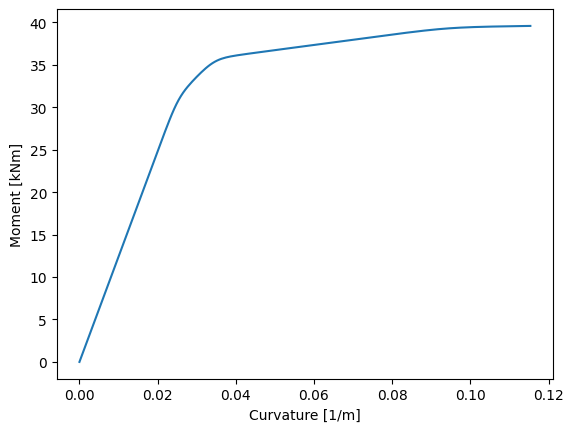

In [9]:
# plotting the results
plt.plot(curvature * 1e3, moment / 1e6)
plt.ylabel("Moment [kNm]")
plt.xlabel("Curvature [1/m]")

In [10]:
slope = moment[25] / curvature[25]
expected_slope = E_steel * I_y

print(f"Slope: {slope/1e9:.2f} x 1e9")
print(f"Expected Slope: {expected_slope/1e9:.2f} x 1e9")

Slope: 1241.11 x 1e9
Expected Slope: 1190.00 x 1e9


In [11]:
print(f"Expected yield curvature: {yield_curvature * 1e3:.3f} 1/m")

Expected yield curvature: 0.023 1/m


In [12]:
expected_My_el = W_ely * f_ym
expected_My_pl = W_ply * f_ym
print(f"Expected yield moment: {expected_My_el / 1e6 :.2f} kNm")
print(f"Expected plastic moment: {expected_My_pl / 1e6 :.2f} kNm")
print(f"Maximum observed moment: {moment[-1] / 1e6:.2f} kNm")

Expected yield moment: 29.09 kNm
Expected plastic moment: 36.51 kNm
Maximum observed moment: 39.59 kNm


The moment curvature response of the cross section is in good agreement with the theoretical values.

### Analysis with the fatigue material

In [13]:
# create basic model of the fibre section
ops.wipe()
ops.model("basic", "-ndm", 3)

ops.node(1, 0, 0, 0, 0, 0, 0)
ops.node(2, 0, 0, 0, 0, 0, 0)

ops.fix(1, 1, 1, 1, 1, 1, 1)
ops.fix(2, 1, 1, 1, 1, 0, 1)

# material
steel_tag = 1
fatigue_tag = 2
mat_tag = fatigue_tag
ops.uniaxialMaterial("Steel02", steel_tag, f_ym, E_steel, b, *[R_0, cR_1, cR_2], a_1, a_2, a_3, a_4)
ops.uniaxialMaterial("Fatigue", fatigue_tag, steel_tag, "-E0", epsilon_0, "-m", m, "-min", -0.2, "-max", 0.2)

# section
sec_tag = 1
GJ = G_steel * J
fib_sec = fibre_CircularHollowSection_basic(diameter, wall_thickness, sec_tag, mat_tag, GJ, n_fibres_circumference, n_fibres_thickness, plot=False)

# element
ele_tag = 1
ops.element("zeroLengthSection", ele_tag, 1, 2, sec_tag)        # local axes align with the global axes

# do a moment-curvature analysis
yield_strain = f_ym / E_steel
yield_curvature = 2 * yield_strain / diameter
max_curvature = 200 * yield_curvature

n_steps = 1000
delta_curvature = max_curvature / n_steps

# create the load pattern
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(2, 0, 0, 0, 0, 1, 0)        # unit moment about the global y axis

# opensees analysis parameters
ops.constraints("Plain")
ops.numberer("RCM")
ops.system("BandGen")
ops.test("NormDispIncr", 1e-6, 50)
ops.algorithm("Newton")
ops.integrator("DisplacementControl", 2, 5, delta_curvature)
ops.analysis("Static")

moment = [ops.getTime()]
curvature = [ops.nodeDisp(2, 5)]

for ii in range(n_steps):
    ops.analyze(1)
    moment.append(ops.getTime())
    curvature.append(ops.nodeDisp(2, 5))

moment = np.array(moment)
curvature = np.array(curvature)

FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed from excessive strain
FatigueMaterial: material tag 2 failed from excessive strain
FatigueMateria

Text(0.5, 0, 'Curvature [1/m]')

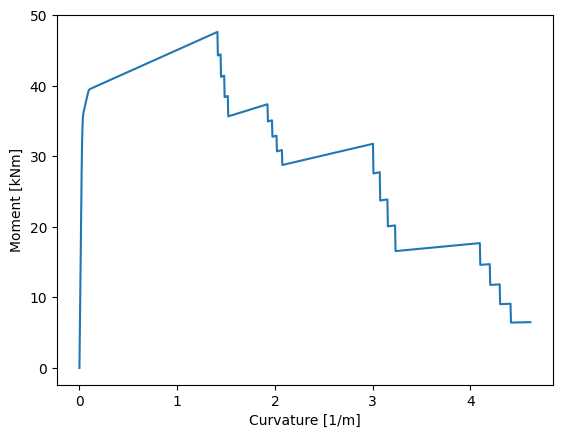

In [14]:
# plotting the results
plt.plot(curvature * 1e3, moment / 1e6)
plt.ylabel("Moment [kNm]")
plt.xlabel("Curvature [1/m]")

In [15]:
# do a single cyclic pushover 
ops.reset()
ops.wipeAnalysis()

U_max = 3.0 * yield_curvature
dU = U_max / 100
offset = 1
dU_factor = 0.1
curvature_path = cyclic_ramp(0, U_max, dU, offset, dU_factor)
curvature_incrs = np.diff(curvature_path)

# create the load pattern
    # same load pattern as before

moment = [ops.getTime()]
curvature = [ops.nodeDisp(2, 5)]

for ii, curvature_incr in enumerate(curvature_incrs):
    # opensees analysis parameters
    ops.wipeAnalysis()
    ops.constraints("Plain")
    ops.numberer("RCM")
    ops.system("BandGen")
    ops.test("NormDispIncr", 1e-6, 50)
    ops.algorithm("Newton")
    ops.integrator("DisplacementControl", 2, 5, curvature_incr)
    ops.analysis("Static")
    
    ops.analyze(1)
    moment.append(ops.getTime())
    curvature.append(ops.nodeDisp(2, 5))

moment = np.array(moment)
curvature = np.array(curvature)


Text(0.5, 0, 'Curvature [1/m]')

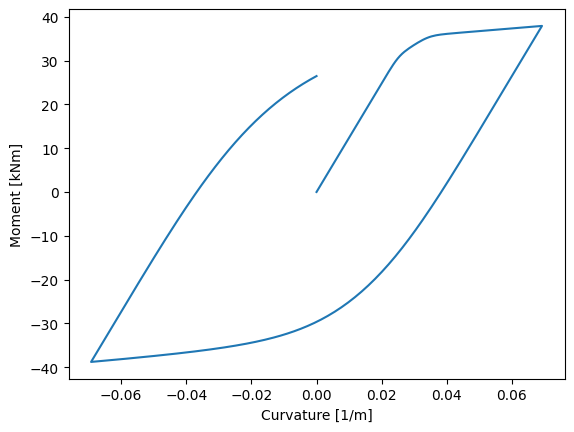

In [16]:
# plotting the results
plt.plot(curvature * 1e3, moment / 1e6)
plt.ylabel("Moment [kNm]")
plt.xlabel("Curvature [1/m]")

In [17]:
# do a multi cycle pushover 
ops.reset()
ops.wipeAnalysis()

U_maxes = np.array([2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 10, 10, 10, 20, 20, 20, 30, 30]) * yield_curvature 
dU = max(U_maxes) / 500
offset = 1
dU_factor = 0.1
curvature_path = multi_cycle_ramp(0, U_maxes, dU, offset, dU_factor)
curvature_incrs = np.diff(curvature_path)

# create the load pattern
    # same load pattern as before

moment = [ops.getTime()]
curvature = [ops.nodeDisp(2, 5)]

for ii, curvature_incr in enumerate(curvature_incrs):
    # opensees analysis parameters
    ops.wipeAnalysis()
    ops.constraints("Plain")
    ops.numberer("RCM")
    ops.system("BandGen")
    ops.test("NormDispIncr", 1e-6, 50)
    ops.algorithm("Newton")
    ops.integrator("DisplacementControl", 2, 5, curvature_incr)
    ops.analysis("Static")
    
    ops.analyze(1)
    moment.append(ops.getTime())
    curvature.append(ops.nodeDisp(2, 5))

moment = np.array(moment)
curvature = np.array(curvature)

FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material tag 2 failed at pseudo peak
FatigueMaterial: material ta

Text(0.5, 0, 'Curvature [1/m]')

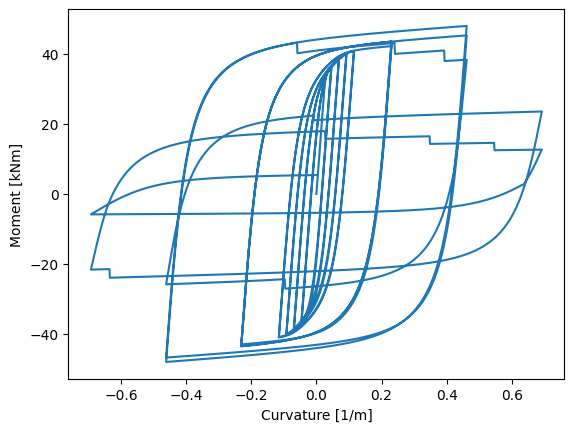

In [18]:
# plotting the results
plt.plot(curvature * 1e3, moment / 1e6)
plt.ylabel("Moment [kNm]")
plt.xlabel("Curvature [1/m]")

## Testing Gusset Hinge

In [19]:
# build a simple model
ops.wipe()
ops.model("basic", "-ndm", 3)

ops.node(1, 0, 0, 0, 0, 0, 0)
ops.node(2, 0, 0, 0, 0, 0, 0)

ops.fix(1, 1, 1, 1, 1, 1, 1)
ops.fix(2, 1, 1, 1, 1, 1, 0)

M_y, K_y, M_z, K_z = gusset_hinge(1, 1, 2, [1, 0, 0], [0, 1, 0], 1, 2, 3,
                                  whitmore_width, effective_length, gusset_thickness, E_steel, f_y_gp,
                                  stiffness = "normal",
                                  nonlinearity = "nonlinear",
                                  rigid_factor = 1e6,
                                  flex_factor = 1e-3,
                                  make_rigid_mat=True
                                 )

print(f"Yield Moment - Y: {M_y/1e6:.2f} kNm")
print(f"Yield Moment - Z: {M_z/1e6:.2f} kNm")
print(f"Rot. Stiff.  - Z: {K_z/1e6:.1f} kNm/rad")

yield_rotation = M_z / K_z
delta_theta = yield_rotation / 10
n_steps = 40

# create the load pattern
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(2, 0, 0, 0, 0, 0, 1)        # unit moment about the global y axis

# opensees analysis parameters
ops.constraints("Plain")
ops.numberer("RCM")
ops.system("BandGen")
ops.test("NormDispIncr", 1e-6, 50)
ops.algorithm("Newton")
ops.integrator("DisplacementControl", 2, 6, delta_theta)
ops.analysis("Static")

moment = [ops.getTime()]
rotation = [ops.nodeDisp(2, 6)]

for ii in range(n_steps):
    ops.analyze(1)
    moment.append(ops.getTime())
    rotation.append(ops.nodeDisp(2, 6))

moment = np.array(moment)
rotation = np.array(rotation)

Yield Moment - Y: 152.51 kNm
Yield Moment - Z: 4.24 kNm
Rot. Stiff.  - Z: 410.6 kNm/rad


Text(0.5, 0, 'Rotation [-]')

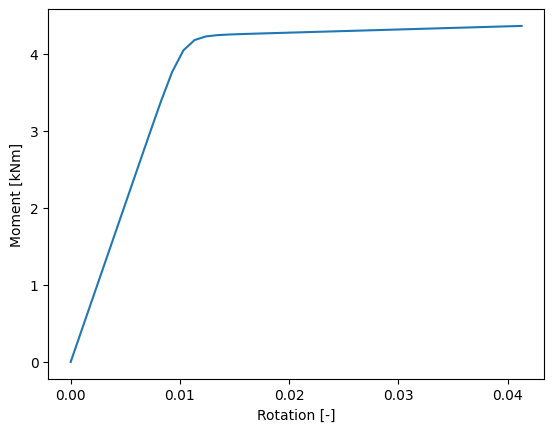

In [20]:
# plotting the results
plt.plot(rotation, moment / 1e6)
plt.ylabel("Moment [kNm]")
plt.xlabel("Rotation [-]")

## Testing Brace Model

### Experimental Setup and Results

The brace was tested in horizontal position and was subjected to direct axial loading. The experimental setup is shown in the following images: 

**!!! INSERT IMAGES !!!**

The following results are from the testing conducted by Fell et al. 2009

In [21]:
# import test data from file
folder = Path("C:/Users/clemettn/OneDrive - Helmut-Schmidt-Universität/01_arbeit/14_PhD/other/Berechnungen/brace_model_validation")
filename = "brace-displacement-Fell_et_al_P1-2.csv"

raw_test_data = np.loadtxt(folder / filename, delimiter=",", skiprows=1)

In [22]:
# clean the test data and remove the initial force from all values and which doesn't match the initial displacement
test_data = np.copy(raw_test_data)
# test_data = test_data[5:, :]
# test_data[:, 1] = test_data[:, 1] - test_data[0, 1]
test_data[:5, :]

array([[ 0.00000e+00,  0.00000e+00],
       [ 9.80000e-03, -2.02175e+01],
       [ 1.83000e-02, -1.99494e+01],
       [ 1.24000e-02, -1.95324e+01],
       [ 1.22000e-02, -1.92940e+01]])

Text(0, 0.5, 'Axial Force [kN]')

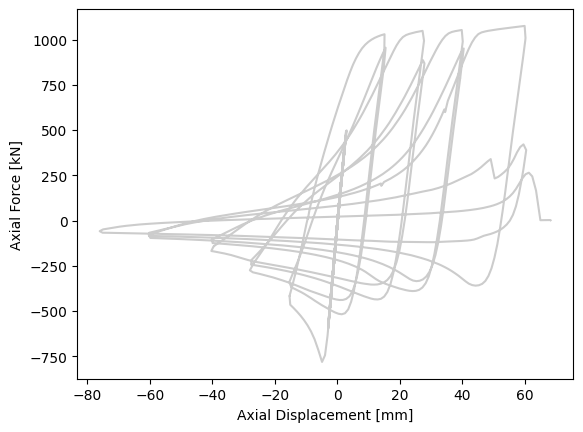

In [23]:
plt.plot(test_data[:,0], test_data[:,1], color="0.8")
plt.xlabel("Axial Displacement [mm]")
plt.ylabel("Axial Force [kN]")

In [24]:
measured_axial_stiffness = 189653      # kN/m  --> converted from Fell et al. 2006 (1083 Kip/in)
peak_compression = min(test_data[:, 1])
print(f"Maximum compression load = {peak_compression} kN")

Maximum compression load = -780.9516 kN


In [25]:
euler_buckling_load = np.pi ** 2 * E_steel * I_y / (k_restraint * brace_length) ** 2
print(f"Euler buckling load = {euler_buckling_load / 1e3:.1f} kN")

Euler buckling load = 1296.3 kN


In [26]:
def create_brace_model(brace_material,
                       oos,
                       oos_dof,
                       oos_shape,
                       n_elements,
                       k_restraint,
                       element_type,
                       transformation,
                       vec_xz,
                       n_integration_points,
                       gusset_stiffness,
                       gusset_nonlinearity,
                       gusset_material,
                       lock_gusset_nodes):
    ops.wipe()
    ops.model("basic", "-ndm", 3)
    
    ni = 1                             # master node end i
    nj = 5                            # master node end j
    gi_tag = 30
    gj_tag = 40
    
    # create the end nodes
    ops.node(ni, 0, 0, 0)
    ops.node(nj, brace_length, 0, 0)
    
    # restraints
    ops.fix(ni, 1, 1, 1, 1, 1, 1)
    ops.fix(nj, 0, 1, 1, 1, 1, 1)
    
    # parameters for defining the brace
    brace_steel_params = [E_steel, G_steel, f_ym]
    brace_section_params = ["CHS", diameter, wall_thickness, i_z, J]
    gusset_steel_params = [E_steel, f_y_gp]
    gusset_i_params = [whitmore_width, effective_length, gusset_thickness]
    gusset_j_params = [whitmore_width, effective_length, gusset_thickness]
    
    # create the brace and gussets
    brace_out = karamanci_brace(10, 30, 40, ni, nj,
                               brace_steel_params,
                               brace_section_params,
                               gusset_steel_params,
                               gusset_i_params,
                               gusset_j_params,
                               brace_material,
                               oos,
                               oos_dof,
                               oos_shape,
                               n_elements,
                               k_restraint,
                               element_type,
                               transformation,
                               vec_xz,
                               n_integration_points,
                               gusset_stiffness,
                               gusset_nonlinearity,
                               gusset_material,
                               lock_gusset_nodes)

    return ni, nj, gi_tag, gj_tag, brace_out

# setup monotonic axial loading
def setup_axial_test(U_max: float, dU: float, direction: int, ctrl_node: int):
    ops.reset()
    # do a simple compression test
    n_steps = int(U_max / dU)

    ops.remove("timeSeries", 1)
    ops.remove("pattern", 1)
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    
    ops.load(ctrl_node, direction, 0, 0, 0, 0, 0)
    
    # opensees analysis parameters
    ops.wipeAnalysis()
    ops.constraints("Plain")
    ops.numberer("RCM")
    ops.system("BandGen")
    ops.test("NormDispIncr", 1e-6, 50)
    ops.algorithm("Newton")
    ops.integrator("DisplacementControl", ctrl_node, 1, direction * dU)
    ops.analysis("Static")

    return n_steps

# analysis function for testing gusset functionality
def axial_analysis(model_out, U_max, direction, dU):
    ni1 = model_out[0]
    nj1 = model_out[1]
    ni2 = model_out[4][0]
    nj2 = model_out[4][1]
    gi_tag = model_out[2]
    
    ctrl_node = nj1
    
    n_steps = setup_axial_test(U_max, dU, direction, ctrl_node)
    
    axial_load = [ops.getTime()]
    axial_displacement = [ops.nodeDisp(ctrl_node, 1)]
    
    gi_ry = [ops.eleResponse(gi_tag, "deformation")[1]]
    gi_rz = [ops.eleResponse(gi_tag, "deformation")[2]]
    gi_Mz = [ops.eleResponse(gi_tag, "localForce")[2]]
    
    for ii in range(n_steps):
        ops.analyze(1)
        axial_load.append(ops.getTime())
        axial_displacement.append(ops.nodeDisp(ctrl_node, 1))
        gi_ry.append(ops.eleResponse(gi_tag, "deformation")[1])
        gi_rz.append(ops.eleResponse(gi_tag, "deformation")[2])
        gi_Mz.append(ops.eleResponse(gi_tag, "localForce")[2])
    
    axial_load = np.array(axial_load)
    axial_displacement = np.array(axial_displacement)
    gi_ry = np.array(gi_ry)
    gi_rz = np.array(gi_rz)
    gi_Mz = np.array(gi_Mz)

    return axial_load, axial_displacement, gi_ry, gi_rz, gi_Mz

### Geometry and Elastic Stiffness

Text(0.5, 0.92, 'XZ Plane')

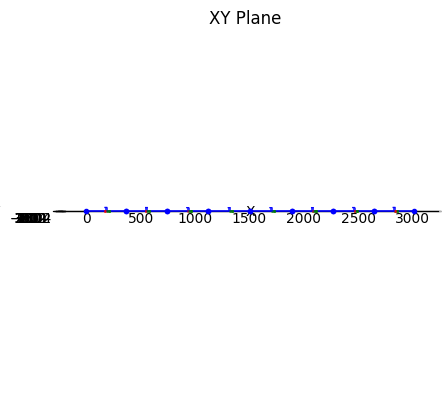

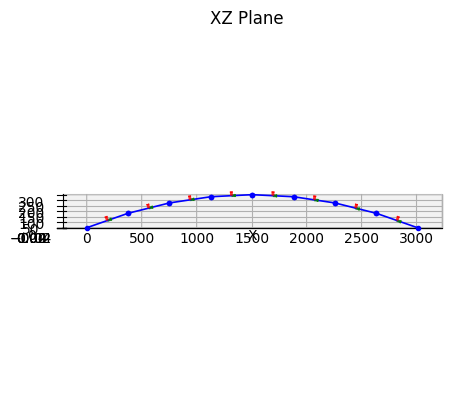

In [27]:
# Plot the model to check the geometry and oos
model_out_A = create_brace_model(brace_material = "Fatigue",
                                 oos = 0.1,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel02",
                                 lock_gusset_nodes = False)

opsv.plot_model(node_labels=False, element_labels=False, gauss_points=False, node_supports=False, az_el=(-90, 90))
plt.title("XY Plane")
opsv.plot_model(node_labels=False, element_labels=False, gauss_points=False, node_supports=False, az_el=(-90, 0))
plt.title("XZ Plane")

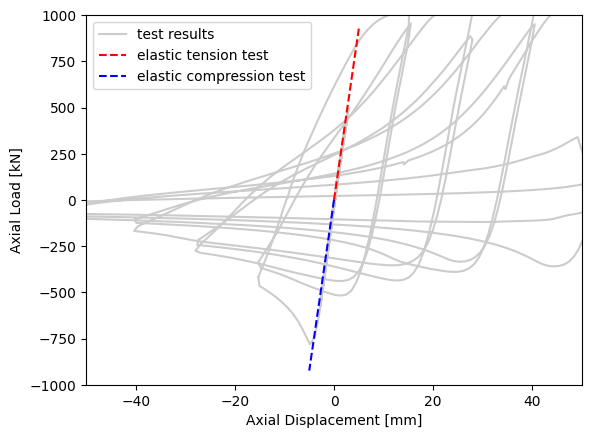

In [28]:
# testing the elastic stiffness
model_out_B = create_brace_model(brace_material = "Elastic",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Steel02",
                                 lock_gusset_nodes = False)

U_max = 5
dU = 0.2
tension_out = axial_analysis(model_out_B, U_max=U_max, direction=1, dU=dU)
compression_out = axial_analysis(model_out_B, U_max=U_max, direction=-1, dU=dU)

#plotting the results
plt.plot(test_data[:,0], test_data[:,1], color="0.8", label="test results")
plt.plot(tension_out[1], tension_out[0] / 1e3, "--r", label="elastic tension test")
plt.plot(compression_out[1], -compression_out[0] / 1e3, "--b", label="elastic compression test")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")
plt.ylim(-1000, 1000)
plt.xlim(-50, 50)
plt.legend()

#### Linear elastic analysis with different gusset stiffnesses

In [29]:
# parameters for the following compression tests
U_max = 50
dU = 0.2
direction=-1

In [30]:
# create model 1 --> elastic with linear gusset with normal stiffness
model_out_1 = create_brace_model(brace_material = "Elastic",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = False)

analysis_1 = axial_analysis(model_out_1, U_max=U_max, direction=direction, dU=dU)

# create model 2 --> elastic with linear gusset with low stiffness
model_out_2 = create_brace_model(brace_material = "Elastic",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "flexible",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = False)

analysis_2 = axial_analysis(model_out_2, U_max=U_max, direction=direction, dU=dU)

# create model 3 --> elastic with linear gusset with high stiffness
model_out_3 = create_brace_model(brace_material = "Elastic",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "rigid",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = False)

analysis_3 = axial_analysis(model_out_3, U_max=U_max, direction=direction, dU=dU)

# create model 4 --> elastic with linear gusset with completely locked/rigid gusset hinges
model_out_4 = create_brace_model(brace_material = "Elastic",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = True)

analysis_4 = axial_analysis(model_out_4, U_max=U_max, direction=direction, dU=dU)

Text(0.5, 0, 'Axial Displacement [mm]')

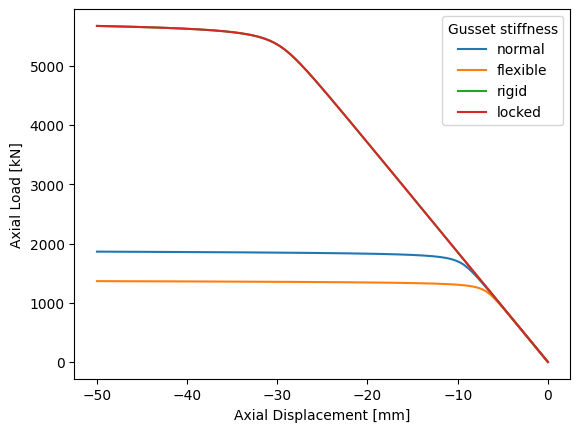

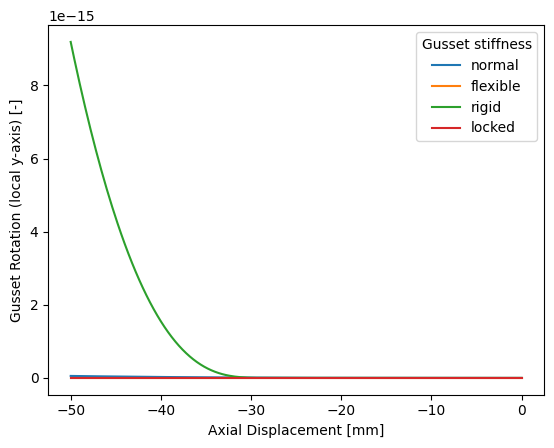

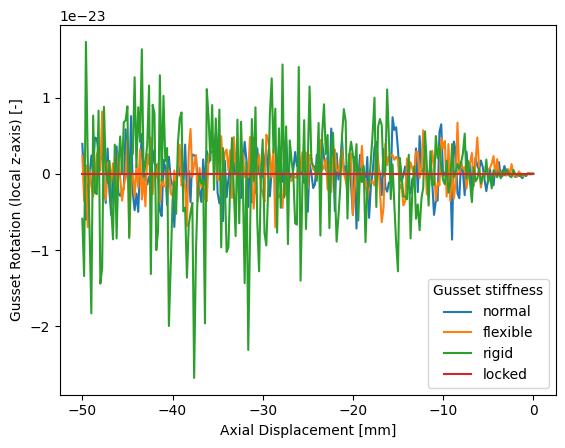

In [31]:
# plotting the results
plt.plot(analysis_1[1], analysis_1[0] / 1e3, label="normal")
plt.plot(analysis_2[1], analysis_2[0] / 1e3, label="flexible")
plt.plot(analysis_3[1], analysis_3[0] / 1e3, label="rigid")
plt.plot(analysis_4[1], analysis_4[0] / 1e3, label="locked")
plt.legend(title="Gusset stiffness")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")

plt.figure()
plt.plot(analysis_1[1], analysis_1[2], label="normal")
plt.plot(analysis_2[1], analysis_2[2], label="flexible")
plt.plot(analysis_3[1], analysis_3[2], label="rigid")
plt.plot(analysis_4[1], analysis_4[2], label="locked")
plt.legend(title="Gusset stiffness")
plt.ylabel("Gusset Rotation (local y-axis) [-]")
plt.xlabel("Axial Displacement [mm]")

plt.figure()
plt.plot(analysis_1[1], analysis_1[3], label="normal")
plt.plot(analysis_2[1], analysis_2[3], label="flexible")
plt.plot(analysis_3[1], analysis_3[3], label="rigid")
plt.plot(analysis_4[1], analysis_4[3], label="locked")
plt.legend(title="Gusset stiffness")
plt.ylabel("Gusset Rotation (local z-axis) [-]")
plt.xlabel("Axial Displacement [mm]")

#### Nonlinear braces (Steel01) with different gusset stiffnesses

In [32]:
# redo the compression test and check the effect of the nonlinear steel materials in the braces
# create model 5 --> Steel01 brace with linear gusset with normal stiffness
model_out_5 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = False)

analysis_5 = axial_analysis(model_out_5, U_max=U_max, direction=direction, dU=dU)

# create model 6 --> Steel01 brace with linear gusset with high stiffness
model_out_6 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "rigid",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = False)

analysis_6 = axial_analysis(model_out_6, U_max=U_max, direction=direction, dU=dU)

# create model 7 --> Steel01 brace with linear gusset with completely locked/rigid gusset hinges
model_out_7 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "forceBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "linear",
                                 gusset_material = "Elastic",
                                 lock_gusset_nodes = True)

analysis_7 = axial_analysis(model_out_7, U_max=U_max, direction=direction, dU=dU)

Text(0.5, 0, 'Axial Displacement [mm]')

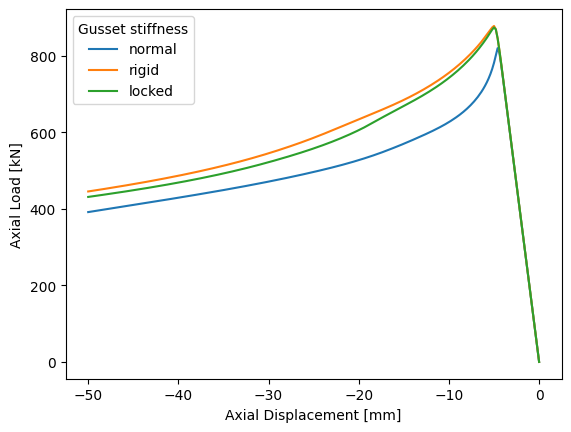

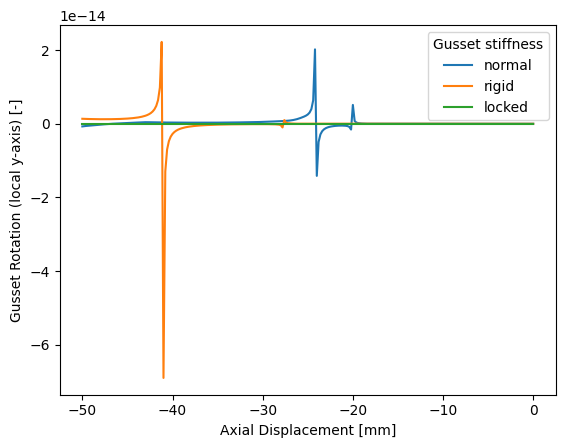

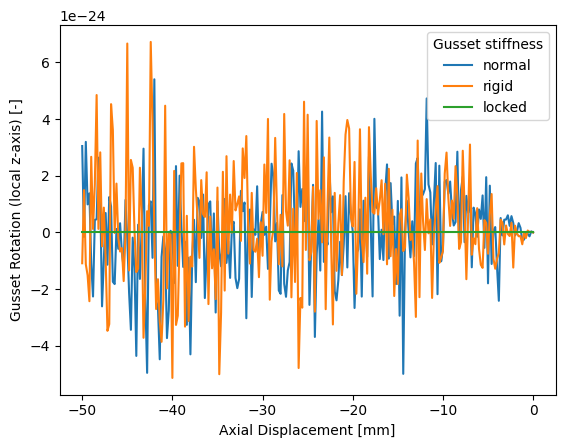

In [33]:
# plotting the results
plt.plot(analysis_5[1], analysis_5[0] / 1e3, label="normal")
plt.plot(analysis_6[1], analysis_6[0] / 1e3, label="rigid")
plt.plot(analysis_7[1], analysis_7[0] / 1e3, label="locked")
plt.legend(title="Gusset stiffness")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")

plt.figure()
plt.plot(analysis_5[1], analysis_5[2], label="normal")
plt.plot(analysis_6[1], analysis_6[2], label="rigid")
plt.plot(analysis_7[1], analysis_7[2], label="locked")
plt.legend(title="Gusset stiffness")
plt.ylabel("Gusset Rotation (local y-axis) [-]")
plt.xlabel("Axial Displacement [mm]")

plt.figure()
plt.plot(analysis_5[1], analysis_5[3], label="normal")
plt.plot(analysis_6[1], analysis_6[3], label="rigid")
plt.plot(analysis_7[1], analysis_7[3], label="locked")
plt.legend(title="Gusset stiffness")
plt.ylabel("Gusset Rotation (local z-axis) [-]")
plt.xlabel("Axial Displacement [mm]")

#### Nonlinear braces (Steel02) with linear gussets with different stiffnesses

In [34]:
# create model 8 --> Steel01 brace with nonlinear gusset (Steel01) with normal stiffness
model_out_8 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel01",
                                 lock_gusset_nodes = False)

analysis_8 = axial_analysis(model_out_8, U_max=U_max, direction=direction, dU=dU)

# create model 9 --> Steel01 brace with nonlinear gusset (Steel01) with high stiffness
model_out_9 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "rigid",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel01",
                                 lock_gusset_nodes = False)

analysis_9 = axial_analysis(model_out_9, U_max=U_max, direction=direction, dU=dU)

# create model 10 --> Steel01 brace with nonlinear gusset (Steel01) with completely locked/rigid gusset hinges
model_out_10 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel01",
                                 lock_gusset_nodes = True)

analysis_10 = axial_analysis(model_out_10, U_max=U_max, direction=direction, dU=dU)

Text(0.5, 0, 'Axial Displacement [mm]')

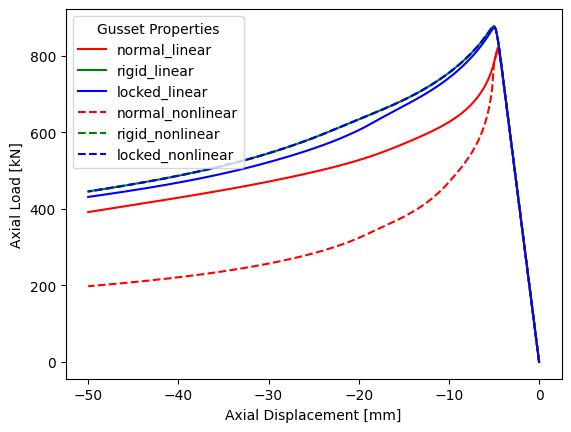

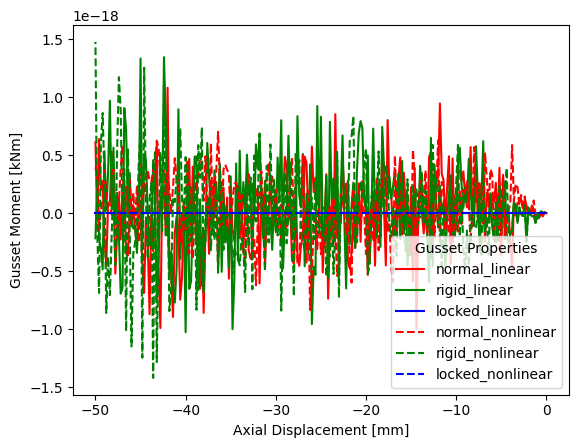

In [35]:
# plotting the results
plt.plot(analysis_5[1], analysis_5[0] / 1e3, "-r", label="normal_linear")
plt.plot(analysis_6[1], analysis_6[0] / 1e3, "-g", label="rigid_linear")
plt.plot(analysis_7[1], analysis_7[0] / 1e3, "-b", label="locked_linear")
plt.plot(analysis_8[1], analysis_8[0] / 1e3, "--r", label="normal_nonlinear")
plt.plot(analysis_9[1], analysis_9[0] / 1e3, "--g", label="rigid_nonlinear")
plt.plot(analysis_10[1], analysis_10[0] / 1e3, "--b", label="locked_nonlinear")
plt.legend(title="Gusset Properties")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")

plt.figure()
plt.plot(analysis_5[1], analysis_5[4] / 1e6, "-r", label="normal_linear")
plt.plot(analysis_6[1], analysis_6[4] / 1e6, "-g", label="rigid_linear")
plt.plot(analysis_7[1], analysis_7[4] / 1e6, "-b", label="locked_linear")
plt.plot(analysis_8[1], analysis_8[4] / 1e6, "--r", label="normal_nonlinear")
plt.plot(analysis_9[1], analysis_9[4] / 1e6, "--g", label="rigid_nonlinear")
plt.plot(analysis_10[1], analysis_10[4] / 1e6, "--b", label="locked_nonlinear")
plt.legend(title="Gusset Properties")
plt.ylabel("Gusset Moment [kNm]")
plt.xlabel("Axial Displacement [mm]")

In [36]:
# # comparison model a and new model function

# # plotting the results
# plt.plot(analysis_8[1], analysis_8[0] / 1e3, "-r", label="A_normal")
# plt.plot(analysis_9[1], analysis_9[0] / 1e3, "-g", label="A_rigid")
# plt.plot(analysis_10[1], analysis_10[0] / 1e3, "-b", label="A_locked")
# plt.plot(analysis_5[1], analysis_5[0] / 1e3, "--r", label="B_normal")
# plt.plot(analysis_6[1], analysis_6[0] / 1e3, "--g", label="B_rigid")
# plt.plot(analysis_7[1], analysis_7[0] / 1e3, "--b", label="B_locked")
# plt.title("Displacement curves - linear gussets")
# plt.legend(title="Model + Gusset Stiff.")
# plt.ylabel("Axial Load [kN]")
# plt.xlabel("Axial Displacement [mm]")

# plt.figure()
# plt.plot(analysis_8[1], analysis_8[4] / 1e6, "-r", label="A_normal")
# plt.plot(analysis_9[1], analysis_9[4] / 1e6, "-g", label="A_rigid")
# plt.plot(analysis_10[1], analysis_10[4] / 1e6, "-b", label="A_locked")
# plt.plot(analysis_5[1], analysis_5[4] / 1e6, "--r", label="B_normal")
# plt.plot(analysis_6[1], analysis_6[4] / 1e6, "--g", label="B_rigid")
# plt.plot(analysis_7[1], analysis_7[4] / 1e6, "--b", label="B_locked")
# plt.title("Gusset Moment curves - linear gussets")
# plt.legend(title="Model + Gusset Stiff.")
# plt.ylabel("Gusset Moment [kNm]")
# plt.xlabel("Axial Displacement [mm]")

# plt.figure()
# plt.plot(analysis_12[1], analysis_12[0] / 1e3, "-r", label="A_normal")
# plt.plot(analysis_13[1], analysis_13[0] / 1e3, "-g", label="A_rigid")
# plt.plot(analysis_14[1], analysis_14[0] / 1e3, "-b", label="A_locked")
# plt.plot(analysis_8[1], analysis_8[0] / 1e3, "--r", label="B_normal")
# plt.plot(analysis_9[1], analysis_9[0] / 1e3, "--g", label="B_rigid")
# plt.plot(analysis_10[1], analysis_10[0] / 1e3, "--b", label="B_locked")
# plt.title("Displacement curves - nonlinear gussets")
# plt.legend(title="Model + Gusset Stiff.")
# plt.ylabel("Axial Load [kN]")
# plt.xlabel("Axial Displacement [mm]")

# plt.figure()
# plt.plot(analysis_a12[1], analysis_a12[4] / 1e6, "-r", label="A_normal")
# plt.plot(analysis_a13[1], analysis_a13[4] / 1e6, "-g", label="A_rigid")
# plt.plot(analysis_a14[1], analysis_a14[4] / 1e6, "-b", label="A_locked")
# plt.plot(analysis_8[1], analysis_8[4] / 1e6, "--r", label="B_normal")
# plt.plot(analysis_9[1], analysis_9[4] / 1e6, "--g", label="B_rigid")
# plt.plot(analysis_10[1], analysis_10[4] / 1e6, "--b", label="B_locked")
# plt.title("Gusset Moment curves - nonlinear gussets")
# plt.legend(title="Model + Gusset Stiff.")
# plt.ylabel("Gusset Moment [kNm]")
# plt.xlabel("Axial Displacement [mm]")

#### Nonlinear Braces (Steel02) and nonlinear Gussets(Steel02)

In [37]:
# create model 11 --> Steel02 brace with nonlinear gusset (Steel01) with normal stiffness
model_out_11 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel01",
                                 lock_gusset_nodes = False)

analysis_11 = axial_analysis(model_out_11, U_max=U_max, direction=direction, dU=dU)

# create model 12 --> Steel02 brace with nonlinear gusset (Steel02) with normal stiffness
model_out_12 = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel02",
                                 lock_gusset_nodes = False)

analysis_12 = axial_analysis(model_out_12, U_max=U_max, direction=direction, dU=dU)

Text(0.5, 0, 'Axial Displacement [mm]')

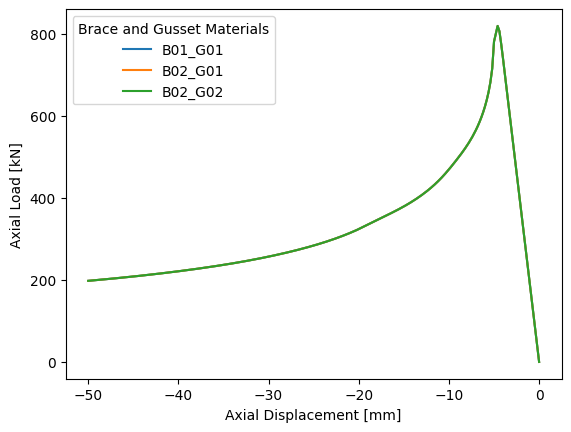

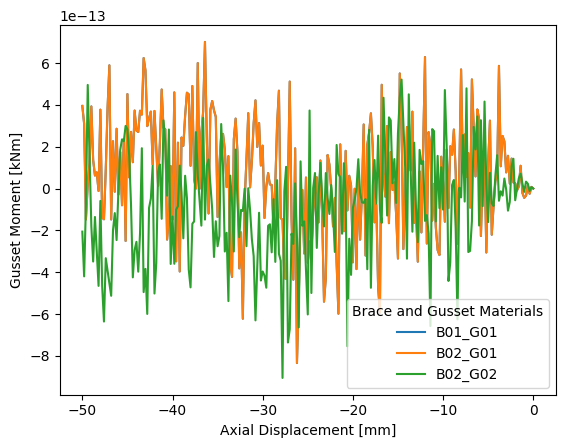

In [38]:
# plotting the results
plt.plot(analysis_8[1], analysis_8[0] / 1e3, label="B01_G01")
plt.plot(analysis_11[1], analysis_11[0] / 1e3, label="B02_G01")
plt.plot(analysis_12[1], analysis_11[0] / 1e3, label="B02_G02")
plt.legend(title="Brace and Gusset Materials")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")

plt.figure()
plt.plot(analysis_8[1], analysis_8[4], label="B01_G01")
plt.plot(analysis_11[1], analysis_11[4], label="B02_G01")
plt.plot(analysis_12[1], analysis_12[4], label="B02_G02")
plt.legend(title="Brace and Gusset Materials")
plt.ylabel("Gusset Moment [kNm]")
plt.xlabel("Axial Displacement [mm]")

#### Cyclic Analysis following experimental displacements

In [39]:
# interpolation function to reduce step size in the data
def interp_path(path, target_spacing):
    values = []
    for U1, U2 in zip(path[:-1], path[1:]):
    
        dU = U2 - U1
        
        if abs(dU) <= target_spacing:
            values.append(U1)
            continue
        else:
            U_temp = U1
            if dU <= 0:
                while U_temp > U2:
                    values.append(U_temp)
                    U_temp -= target_spacing
                    
            else:
                while U_temp < U2:
                    values.append(U_temp)
                    U_temp += target_spacing
                    
    
            continue
    values.append(path[-1])

    return values

# run a cyclic analysis following the test data displacements
def analyse_experiment(model_out, n_loading_points, max_step):
    ni1 = model_out[0]
    nj1 = model_out[1]
    ni2 = model_out[4][0]
    nj2 = model_out[4][1]
    gi_tag = model_out[2]
    
    ctrl_node = nj1

    if n_loading_points == 0:
        x = len(test_data[:,0])
    else:
        x = n_loading_points
        
    resampled_path  = interp_path(test_data[:,0][:x], max_step)
    
    # displacement increments from test data
    displacement_incrs = np.diff(resampled_path)
    
    dof = 1
    
    # create the load pattern
    ops.remove("loadPattern", 1)
    ops.remove("timeSeries", 1)
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)
    
    ops.load(ctrl_node, 1, 0, 0, 0, 0, 0)
    
    axial_load = [ops.getTime()]
    axial_displacement = [ops.nodeDisp(ctrl_node, dof)]
    
    # opensees analysis parameters
    ops.wipeAnalysis()
    ops.constraints("Plain")
    ops.numberer("RCM")
    ops.system("BandGen")
    # ops.test("NormUnbalance", 1e-5, 50)
    ops.test("NormDispIncr", 1e-6, 50)
    ops.algorithm("KrylovNewton")
    
    for ii, displacement_incr in enumerate(displacement_incrs):
        ops.integrator("DisplacementControl", ctrl_node, dof, displacement_incr)
        ops.analysis("Static")
        ops.analyze(1)
        axial_load.append(ops.getTime())
        axial_displacement.append(ops.nodeDisp(ctrl_node, dof))
    
    axial_load = np.array(axial_load)
    axial_displacement = np.array(axial_displacement)

    return axial_load, axial_displacement

In [40]:
# model with steel 02 and no fatigue
model_out_A = create_brace_model(brace_material = "Steel02",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel02",
                                 lock_gusset_nodes = False)

n_loading_points = 1500
max_step = 0.4
experiment_out_A = analyse_experiment(model_out_A, n_loading_points, max_step)

(-100.0, 100.0)

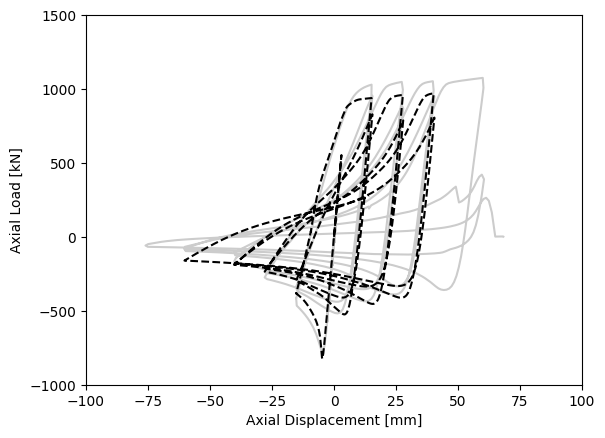

In [41]:
# plotting the results
plt.plot(test_data[:,0], test_data[:,1], color="0.8")
plt.plot(experiment_out_A[1], experiment_out_A[0] / 1e3, "--k")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")
plt.ylim(-1000, 1500)
plt.xlim(-100, 100)

In [42]:
# model with steel 02 and with fatigue failure
model_out_B = create_brace_model(brace_material = "Fatigue",
                                 oos = 0.001,
                                 oos_dof = 3,
                                 oos_shape = "parabolic",
                                 n_elements = 8,
                                 k_restraint=k_restraint,
                                 element_type = "dispBeamColumn",
                                 transformation = "Corotational",
                                 vec_xz = [0, 0, 1],
                                 n_integration_points = 5,
                                 gusset_stiffness = "normal",
                                 gusset_nonlinearity = "nonlinear",
                                 gusset_material = "Steel02",
                                 lock_gusset_nodes = False)

n_loading_points = 0
max_step = 0.4
experiment_out_B = analyse_experiment(model_out_B, n_loading_points, max_step)

FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMaterial: material tag 10 failed at pseudo peak
FatigueMat

(-100.0, 100.0)

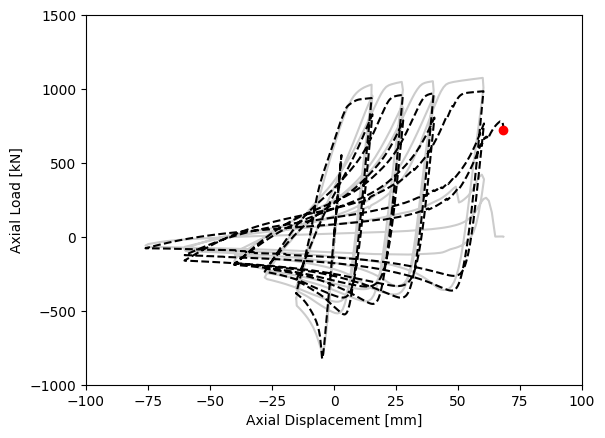

In [43]:
# plotting the results
plt.plot(test_data[:,0], test_data[:,1], color="0.8")
plt.plot(experiment_out_B[1], experiment_out_B[0] / 1e3, "--k")
plt.plot(experiment_out_B[1][-1], experiment_out_B[0][-1] / 1e3, marker="o", color="r")
plt.ylabel("Axial Load [kN]")
plt.xlabel("Axial Displacement [mm]")
plt.ylim(-1000, 1500)
plt.xlim(-100, 100)

(-80.0, 80.0)

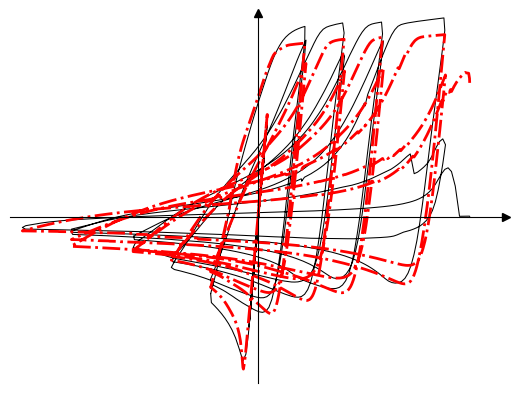

In [53]:
# plotting the results
fig = plt.figure()
ax = plt.gca()
ax.plot(test_data[:,0], test_data[:,1], color="k", linewidth=0.75)
ax.plot(experiment_out_B[1], experiment_out_B[0] / 1e3, "-.r", linewidth=2)

ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)

ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

# ax.set_ylabel("Axial Load [kN]")
# ax.set_xlabel("Axial Displacement [mm]")
# ax.grid(visible=True, which="major", color="0.7", linestyle="-.")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
ax.set_ylim(-900, 1100)
ax.set_xlim(-80, 80)

